<h2>Formula 1 Grand Prix qualifying prediction</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV,train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error,mean_absolute_error
import pickle


plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [2]:
results = pd.read_csv(r'data/results.csv')
races = pd.read_csv(r'data/races.csv')
qualifyings = pd.read_csv(r'data/qualifying.csv')
drivers = pd.read_csv(r'data/drivers.csv')
constructors = pd.read_csv(r'data/constructors.csv')
circuits = pd.read_csv(r'data/circuits.csv')
status = pd.read_csv(r'data/status.csv')
laptimes = pd.read_csv(r'data/lap_times.csv')


countries = pd.read_csv(r'data/countries/countries.csv')

In [3]:
df1 = pd.merge(races,results,how='left',on=['raceId'], suffixes=('_race', '_result'))
df2 = pd.merge(df1,qualifyings,how='left',on=['raceId','driverId','constructorId'], suffixes=('', '_qualifying'))
df3 = pd.merge(df2,drivers,how='left',on=['driverId'], suffixes=('', '_driver'))
df4 = pd.merge(df3,constructors,how='left',on=['constructorId'], suffixes=('', '_constructor'))
df5 = pd.merge(df4,circuits,how='left',on=['circuitId'], suffixes=('', '_circuit'))

In [4]:

data = df5;
#drop the columns which are not important


data = data.drop(['raceId',  'round', 'circuitId', 'name', 'time_race', 'milliseconds',
       'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time','quali_date', 'quali_time', 'sprint_date', 'sprint_time','weather',
       'resultId', 'constructorId', 'number', 'grid', 'position',
       'positionText','positionOrder', 'points', 'laps','time_result',
        'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_qualifying',
       'position_qualifying', 'driverRef', 'number_driver',
       'code',   'url_driver',
       'constructorRef', 
       'url_constructor', 'circuitRef',  'location',
       'lat', 'lng', 'alt', 'url_circuit'
      ],axis=1)

In [5]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData = testData[(testData['year'] == 2020) & (testData['name_circuit'] == 'Bahrain International Circuit')] 

#export test data to csv
#testData.to_csv('testData.csv', index=False)


In [6]:
#rename the columns
data.rename(columns={'name':'race_name','name_constructor':'constructor',
                     'nationality':'driver_nationality','nationality_constructor':'constructor_nationality', 'name_circuit' :'circuit', 'country': 'country_circuit', 'type': 'type_circuit'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
#drop forename columns and surname columns
data = data.drop(['forename','surname'],axis=1)

def convert_to_full_date(date_str):
    day, month, year = date_str.split('-')
    year = int(year)
    # Assume years < 50 are in 2000s, otherwise in 1900s
    full_year = 2000 + year if year < 50 else 1900 + year
    return f"{day}-{month}-{full_year}"
# Specify the date format explicitly
data['full_date'] = data['date'].apply(convert_to_full_date)
data['date'] = pd.to_datetime(data['full_date'], format='%d-%m-%Y', errors='coerce')
data = data.drop(['full_date'],axis=1)
data['dob'] = pd.to_datetime(data['dob'], format='%Y-%m-%d', errors='coerce')


In [7]:
data

,year,date,driverId,q1,q2,q3,dob,driver_nationality,constructor,constructor_nationality,circuit,country_circuit,type_circuit,driver
0,1950,1950-05-13,642,NaN,NaN,NaN,1906-10-30,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,Nino Farina
1,1950,1950-05-13,786,NaN,NaN,NaN,1898-06-09,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,Luigi Fagioli
2,1950,1950-05-13,686,NaN,NaN,NaN,1911-07-02,British,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,Reg Parnell
3,1950,1950-05-13,704,NaN,NaN,NaN,1904-10-08,French,Talbot-Lago,French,Silverstone Circuit,UK,Race circuit,Yves Cabantous
4,1950,1950-05-13,627,NaN,NaN,NaN,1905-11-05,French,Talbot-Lago,French,Silverstone Circuit,UK,Race circuit,Louis Rosier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,2024,2024-12-08,825,1:23.632,1:23.877,\N,1992-10-05,Danish,Haas F1 Team,American,Yas Marina Circuit,UAE,Race circuit,Kevin Magnussen
26755,2024,2024-12-08,859,1:23.733,1:23.472,\N,2002-02-11,New Zealander,RB F1 Team,Italian,Yas Marina Circuit,UAE,Race circuit,Liam Lawson
26756,2024,2024-12-08,822,1:23.481,1:23.341,1:23.204,1989-08-28,Finnish,Sauber,Swiss,Yas Marina Circuit,UAE,Race circuit,Valtteri Bottas
26757,2024,2024-12-08,861,1:23.912,\N,\N,2003-05-27,Argentinian,Williams,British,Yas Marina Circuit,UAE,Race circuit,Franco Colapinto


In [8]:
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driverId')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driverId', how='left')
data = data.drop(['driverId'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [9]:
#select all data from 1980
data = data[data['year']>=1980]
#get first nationality only


In [10]:
print(data.columns)

Index(['year', 'date', 'q1', 'q2', 'q3', 'dob', 'driver_nationality',
       'constructor', 'constructor_nationality', 'circuit', 'country_circuit',
       'type_circuit', 'driver', 'age_at_gp_in_days', 'first_race_date',
       'days_since_first_race'],
      dtype='object')


In [11]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['Williams' 'Brabham' 'Fittipaldi' 'Tyrrell' 'Alfa Romeo' 'McLaren'
 'Ferrari' 'Ensign' 'Ligier' 'Arrows' 'ATS' 'Team Lotus' 'Renault'
 'Shadow' 'Osella' 'Theodore' 'March' 'Toleman' 'RAM' 'Spirit' 'Minardi'
 'Zakspeed' 'Lola' 'Benetton' 'AGS' 'Larrousse' 'Coloni' 'Rial'
 'Euro Brun' 'Dallara' 'Onyx' 'Leyton House' 'Life' 'Lambo' 'Jordan'
 'Footwork' 'Fondmetal' 'Andrea Moda' 'Sauber' 'Simtek' 'Pacific' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Toyota' 'Red Bull' 'Honda' 'Toro Rosso'
 'BMW Sauber' 'MF1' 'Super Aguri' 'Spyker MF1' 'Spyker' 'Force India'
 'Brawn' 'Mercedes' 'Lotus' 'HRT' 'Virgin' 'Lotus F1' 'Marussia'
 'Caterham' 'Manor Marussia' 'Haas F1 Team' 'Racing Point' 'AlphaTauri'
 'Aston Martin' 'Alpine F1 Team' 'RB F1 Team']


In [12]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='BMW Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='RB F1 Team' else x)

In [13]:
data['constructor_nationality'].unique()


array(['British', 'Brazilian', 'Swiss', 'Italian', 'French', 'Hong Kong',
       'German', 'Irish', 'Japanese', 'Austrian', 'Russian', 'Dutch',
       'Indian', 'Malaysian', 'Spanish', 'American'], dtype=object)

In [14]:
#clean data
data['driver_nationality'] = data['driver_nationality'].replace('Argentinian', 'Argentine')
data['country_circuit'] = data['country_circuit'].replace('United States', 'USA')

In [15]:
#for country circuit

#Change all "Argentinian" to "Argentine"
data_tmp = data.copy()

#get first nationality only
df_countries = countries.copy()
df_countries['nationality'] = df_countries['nationality'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UK' if x=='United Kingdom of Great Britain and Northern Ireland' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UAE' if x=='United Arab Emirates' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Korea' if x=='Korea (Republic of)' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Russia' if x=='Russian Federation' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'USA' if x=='United States of America' else x)

#drop rows with duplicate nationality
df_countries = df_countries[df_countries['en_short_name'] != 'Taiwan']
df_countries = df_countries[df_countries['en_short_name'] != 'United States Minor Outlying Islands']


data_with_circuit_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='country_circuit', 
    right_on='en_short_name'  
)

#en_short_name

data_with_circuit_nationality=data_with_circuit_nationality.drop(['country_circuit', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_circuit_nationality.rename(columns={'alpha_3_code':'circuit_nationality'}, inplace=True)


In [16]:
data_tmp = data_with_circuit_nationality.copy()

data_with_driver_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='driver_nationality', 
    right_on='nationality'  
)

data_with_driver_nationality=data_with_driver_nationality.drop(['driver_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_driver_nationality.rename(columns={'alpha_3_code':'driver_nationality'}, inplace=True)



In [17]:
data_tmp = data_with_driver_nationality.copy()

data_with_constructor_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='constructor_nationality', 
    right_on='nationality'  
)
data_with_constructor_nationality=data_with_constructor_nationality.drop(['constructor_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_constructor_nationality.rename(columns={'alpha_3_code':'constructor_nationality'}, inplace=True)


In [18]:
#data after processing nationalities
data = data_with_constructor_nationality;
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


In [21]:
data_cleaned_quali_time = data.copy()

# Replace invalid values with a default time (e.g., '0:00.000')
data_cleaned_quali_time['q1'] = data_cleaned_quali_time['q1'].fillna('0:00.000').replace('/N', '0:00.000')
data_cleaned_quali_time['q2'] = data_cleaned_quali_time['q2'].fillna('0:00.000').replace('/N', '0:00.000')
data_cleaned_quali_time['q3'] = data_cleaned_quali_time['q3'].fillna('0:00.000').replace('/N', '0:00.000')

# Prepend '00:' to convert to hh:mm:ss format
data_cleaned_quali_time['q1'] = pd.to_timedelta('00:' + data_cleaned_quali_time['q1'], errors='coerce')
data_cleaned_quali_time['q2'] = pd.to_timedelta('00:' + data_cleaned_quali_time['q2'], errors='coerce')
data_cleaned_quali_time['q3'] = pd.to_timedelta('00:' + data_cleaned_quali_time['q3'], errors='coerce')

#convert q1 q2 q3 to milliseconds
data_cleaned_quali_time['q1'] = data_cleaned_quali_time['q1'].dt.total_seconds() * 1000
data_cleaned_quali_time['q2'] = data_cleaned_quali_time['q2'].dt.total_seconds() * 1000
data_cleaned_quali_time['q3'] = data_cleaned_quali_time['q3'].dt.total_seconds() * 1000

data_cleaned_quali_time['q1'] = data_cleaned_quali_time['q1'].fillna(0)
data_cleaned_quali_time['q2'] = data_cleaned_quali_time['q2'].fillna(0)
data_cleaned_quali_time['q3'] = data_cleaned_quali_time['q3'].fillna(0)
#get fastest time out of q1, q2,q3 for each row and set as qualifying time
data_cleaned_quali_time['milliseconds_qualification'] = data_cleaned_quali_time[['q1', 'q2', 'q3']].max(axis=1)

#drop
data_cleaned_quali_time = data_cleaned_quali_time.drop(['q1', 'q2', 'q3'], axis=1)
#drop if milliseconds_qualification is 0
data_cleaned_quali_time = data_cleaned_quali_time[data_cleaned_quali_time['milliseconds_qualification'] != 0]
data_cleaned_quali_time.drop_duplicates(inplace=True)
data_cleaned_quali_time



,year,date,dob,constructor,circuit,type_circuit,driver,age_at_gp_in_days,first_race_date,days_since_first_race,circuit_nationality,driver_nationality,constructor_nationality,driver_home,constructor_home,milliseconds_qualification
6474,1994,1994-03-27,1969-01-03,Benetton,Autódromo José Carlos Pace,Race circuit,Michael Schumacher,9214,1991-08-25,945,BRA,DEU,ITA,0,0,76290.00
6475,1994,1994-03-27,1960-09-17,Williams,Autódromo José Carlos Pace,Race circuit,Damon Hill,12244,1992-05-03,693,BRA,GBR,GBR,0,0,77554.00
6476,1994,1994-03-27,1964-06-11,Ferrari,Autódromo José Carlos Pace,Race circuit,Jean Alesi,10881,1989-07-09,1722,BRA,FRA,ITA,0,0,77385.00
6477,1994,1994-03-27,1972-05-23,Jordan,Autódromo José Carlos Pace,Race circuit,Rubens Barrichello,7978,1993-03-14,378,BRA,BRA,IRL,1,0,78414.00
6478,1994,1994-03-27,1963-05-29,Tyrrell,Autódromo José Carlos Pace,Race circuit,Ukyo Katayama,11260,1992-03-01,756,BRA,JPN,GBR,0,0,78194.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18827,2024,2024-12-08,1992-10-05,Haas F1 Team,Yas Marina Circuit,Race circuit,Kevin Magnussen,11752,2014-03-16,3920,ARE,DNK,USA,0,0,83877.00
18828,2024,2024-12-08,2002-02-11,AlphaTauri,Yas Marina Circuit,Race circuit,Liam Lawson,8336,2023-08-27,469,ARE,NZL,ITA,0,0,83733.00
18829,2024,2024-12-08,1989-08-28,Alfa Romeo,Yas Marina Circuit,Race circuit,Valtteri Bottas,12886,2013-03-17,4284,ARE,FIN,CHE,0,0,83481.00
18830,2024,2024-12-08,2003-05-27,Williams,Yas Marina Circuit,Race circuit,Franco Colapinto,7866,2024-09-01,98,ARE,ARG,GBR,0,0,83912.00


In [30]:
#drop where milliseconds_qualification larger than 1000000
data_median = data_cleaned_quali_time[data_cleaned_quali_time['milliseconds_qualification'] < 1000000]



data_median_qualification = data_median.groupby(['circuit', 'year', 'date'])['milliseconds_qualification'].median().reset_index()
#rename col to median_race_duration
data_median_qualification.rename(columns={'milliseconds_qualification': 'median_qualification_duration'},inplace=True)

#merge with data_median
data_median = data_median.merge(data_median_qualification, on=['circuit', 'year', 'date'], how='left')

#create column deviation from median and equal to abs of race_duration - median_race_duration
data_median['deviation_from_median'] = data_median['milliseconds_qualification'] - data_median['median_qualification_duration']


#round all numbers in num columns
num_cols = data_median.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data_median[col] = data_median[col].round()

#export to csv
data_median.to_csv('data_cleaned_quali_time.csv', index=False)

<h3>Testing different models on cleaned qualifying data</h3>

In [32]:
# Drop irrelevant columns
columns_to_drop = [ 'dob', 'date', 'first_race_date','median_qualification_duration','milliseconds_qualification']
data_quali_time_prepared = data_median.drop(columns=columns_to_drop)

data_quali_time_prepared.dtypes

year                         int64
constructor                 object
circuit                     object
type_circuit                object
driver                      object
age_at_gp_in_days            int32
days_since_first_race        int32
circuit_nationality         object
driver_nationality          object
constructor_nationality     object
driver_home                  int64
constructor_home             int64
deviation_from_median      float64
dtype: object

In [33]:
y = data_quali_time_prepared['deviation_from_median']
X = data_quali_time_prepared.drop(columns=['deviation_from_median'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [36]:
y_train

9031     885.00
8100     -58.00
8400     796.00
828      -96.00
6964    -276.00
         ...   
5734    -296.00
5191     239.00
5390   10750.00
860      667.00
7270    -666.00
Name: deviation_from_median, Length: 8261, dtype: float64

<h3> Random forest regressor</h3>

In [34]:

# Identify column types
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
     'model__max_depth': [30],
     'model__min_samples_leaf': [2, 3, 4],
     'model__min_samples_split': [10, 15],
     'model__n_estimators': [600, 800]
}

#'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)
 
# Fit
grid_search.fit(X_train, y_train)


# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 15, 'model__n_estimators': 800}
Best RMSE: 1579.3020815384461
Final Model Performance:
MSE: 5374850.65
RMSE: 2318.37
R2: 0.1528
MAE: 761.05


C:\Users\Admin\AppData\Local\Temp\ipykernel_49416\1344995424.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


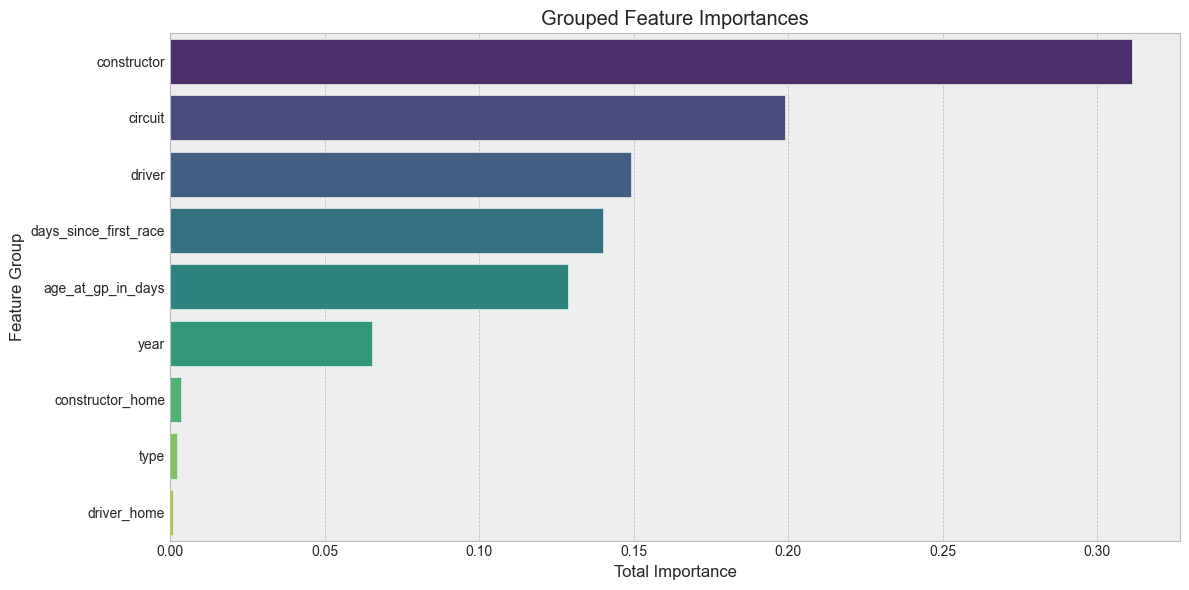

In [37]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

# Get preprocessor and trained model
preprocessor = best_pipeline.named_steps['preprocessing']
model = best_pipeline.named_steps['model']

# Extract feature names after preprocessing
# 1. Numeric feature names (not transformed)
num_features = num_cols

# 2. Categorical one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)

# 3. Combine both
feature_names = np.concatenate([num_features, cat_features])

# 4. Extract feature importances from the model
importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [ ]:
# save
with open('rf_qualification.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


<h5>Gradient boost regressor</h5>

In [ ]:
# Identify column types
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__loss': [ 'huber'],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [ 300, 400],
    'model__min_samples_split': [ 5, 10, 15],
    'model__min_samples_leaf': [ 4, 5],
    'model__max_depth': [ 4, 5],
}

# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)


# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RMSE: 89.46023855369367
Final Model Performance:
MSE: 7135.10
RMSE: 84.47
R2: 0.4016
MAE: 25.27


/tmp/ipykernel_2347/2472914946.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


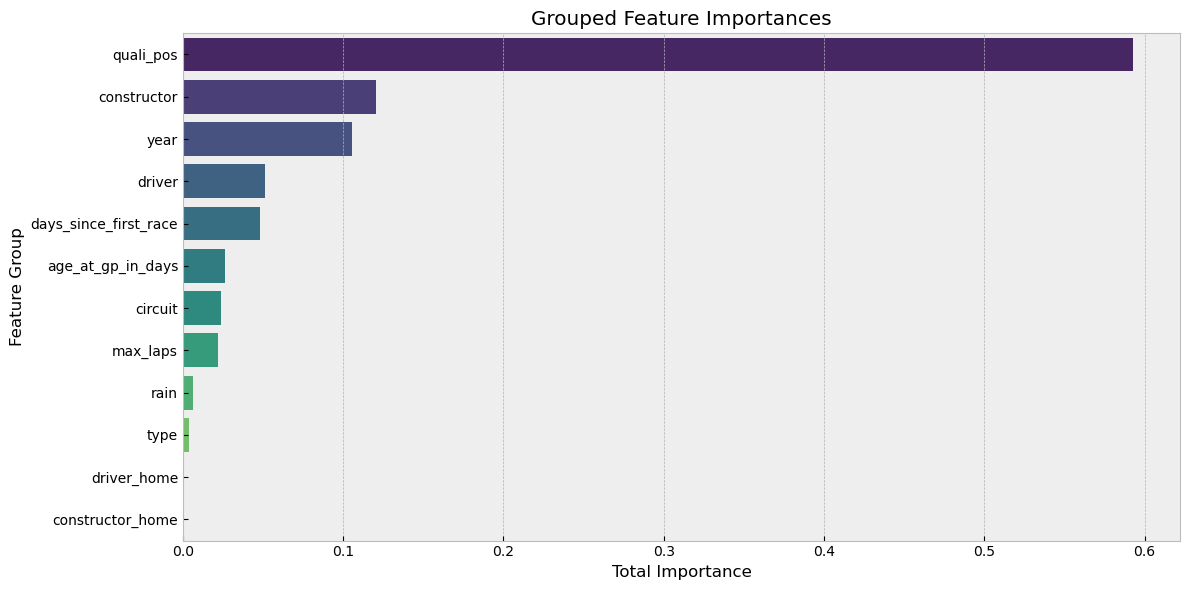

In [ ]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

# Get preprocessor and trained model
preprocessor = best_pipeline.named_steps['preprocessing']
model = best_pipeline.named_steps['model']

# Extract feature names after preprocessing
# 1. Numeric feature names (not transformed)
num_features = num_cols

# 2. Categorical one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)

# 3. Combine both
feature_names = np.concatenate([num_features, cat_features])

# 4. Extract feature importances from the model
importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [ ]:
# save
with open('gb_qualification.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>Neural network</h5>

In [38]:

# Identify column types
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', MLPRegressor(random_state=42, hidden_layer_sizes=(100, 100, 100, 100, 100), activation='relu', alpha=0.0001, learning_rate_init=0.001, solver='adam',max_iter=500 , verbose=1))
])

param_grid = {
    'model__hidden_layer_sizes': [ (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01],
    'model__solver': ['adam'],
}
# Cross-validation
# k = 5
# cv = KFold(n_splits=k, shuffle=True, random_state=42)
# 
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            cv=cv,
#                            scoring='neg_mean_squared_error',
#                            verbose=1,
#                            n_jobs=-1)

# grid_search.fit(X, y)



# print("Best Parameters:", grid_search.best_params_)
# best_rmse = np.sqrt(-grid_search.best_score_)
# print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

# best_model_nn = grid_search.best_estimator_
best_model_nn = pipeline.fit(X_train, y_train)
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Iteration 1, loss = 1738018.13488610
Iteration 2, loss = 1647217.89715101
Iteration 3, loss = 1418560.71895521
Iteration 4, loss = 1303593.88102360
Iteration 5, loss = 1247863.71538929
Iteration 6, loss = 1218579.95236604
Iteration 7, loss = 1190766.94949114
Iteration 8, loss = 1169675.41376971
Iteration 9, loss = 1153473.88068330
Iteration 10, loss = 1138155.44381216
Iteration 11, loss = 1112270.85180313
Iteration 12, loss = 1091666.80085642
Iteration 13, loss = 1069813.74338375
Iteration 14, loss = 1041492.89475140
Iteration 15, loss = 1011252.45916147
Iteration 16, loss = 976445.40277386
Iteration 17, loss = 939831.47317344
Iteration 18, loss = 897120.71291791
Iteration 19, loss = 859752.98719082
Iteration 20, loss = 856455.21288477
Iteration 21, loss = 807206.84711903
Iteration 22, loss = 810558.61033432
Iteration 23, loss = 774616.25975083
Iteration 24, loss = 756199.59024385
Iteration 25, loss = 738461.82396403
Iteration 26, loss = 738764.74796672
Iteration 27, loss = 723802.7550

In [40]:
# save
with open('nn_qualification.pkl','wb') as f:
    pickle.dump(best_model_nn,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)